In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

# append source
import os, sys

partial_equiv_source = os.path.join(os.getcwd(), '..')
if partial_equiv_source not in sys.path:
    sys.path.append(partial_equiv_source)

from partial_equiv.partial_gconv.conv import LiftingConv, GroupConv
import partial_equiv.groups as groups

# visualization_utilities
from visualization_utils import (
    visualize_lifting_coordinate_grids, visualize_lifting_kernels,
    visualize_group_coordinate_grids, visualize_group_kernels,
    visualize_activations,
)

In [3]:
device = 'cpu'
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
from omegaconf import OmegaConf

# Get the template of the config file used in the experiments
config_template = OmegaConf.load(os.path.join(partial_equiv_source, 'cfg/config.yaml'))

# Get templates of the config files for the group, kernel and conv.
group_config = config_template.base_group
kernel_config = config_template.kernel
conv_config = config_template.conv

In [5]:
# Modify them

# Group
group_config.no_samples = 8
group_config.sampling_method = groups.SamplingMethods.DETERMINISTIC
print(OmegaConf.to_yaml(group_config))

# Kernel
kernel_config.type = "SIREN"
kernel_config.no_hidden = 32
kernel_config.no_layers = 3
kernel_config.size = "7"
kernel_config.omega0 = 10.0
print(OmegaConf.to_yaml(kernel_config))

# Conv
conv_config.padding = "same"
conv_config.partial_equiv = False
print(OmegaConf.to_yaml(conv_config))

name: ''
no_samples: 8
sample_per_batch_element: false
sample_per_layer: false
sampling_method: DETERMINISTIC
gumbel_init_temp: 0.5
gumbel_end_temp: 0.0001

type: SIREN
no_hidden: 32
no_layers: 3
size: '7'
omega0: 10.0
learn_omega0: false
weight_norm: false
norm: ''
activation: ''

padding: same
partial_equiv: false
bias: true



In [6]:
group = groups.E2()

liftconv = LiftingConv(
    in_channels=1,
    out_channels=20,
    group=group,
    base_group_config=group_config,
    kernel_config=kernel_config,
    conv_config=conv_config,
)

gconv = GroupConv(
    in_channels=20,
    out_channels=5,
    group=group,
    base_group_config=group_config,
    kernel_config=kernel_config,
    conv_config=conv_config,
)
liftconv, gconv = liftconv.to(device), gconv.to(device)

In [7]:
x = torch.rand([50, 1, 21, 21], device=device)

In [8]:
out_lift, g_elems = liftconv(x)
out_group = gconv([out_lift, g_elems])

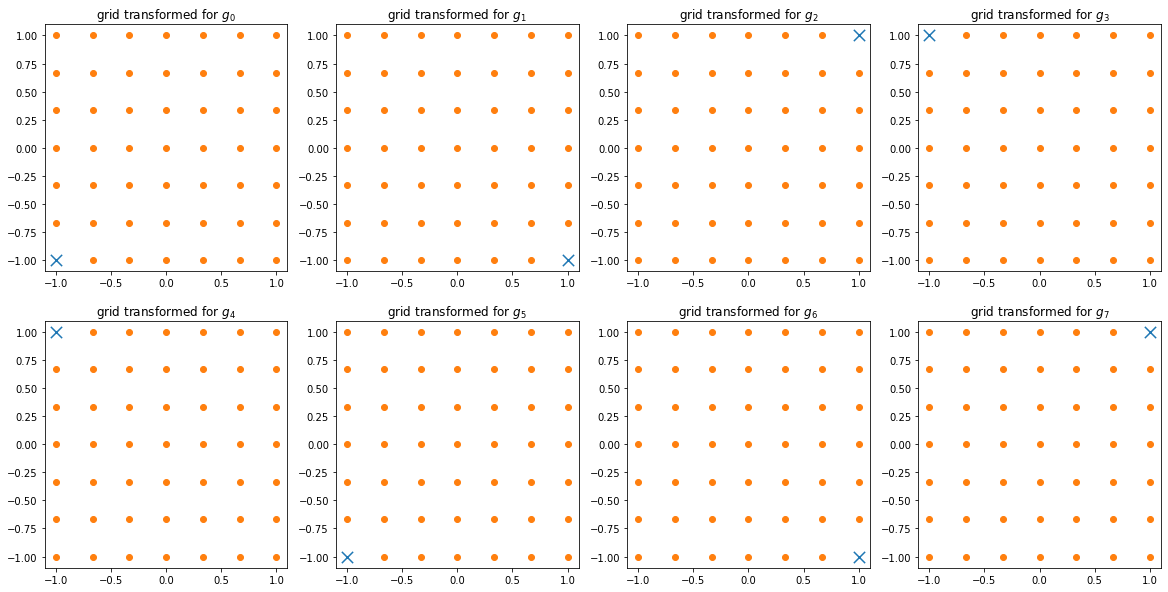

In [9]:
visualize_lifting_coordinate_grids(liftconv.acted_rel_pos)

tensor([[[ 0.0000,  1.0000],
         [ 1.5708,  1.0000],
         [ 3.1416,  1.0000],
         [ 4.7124,  1.0000],
         [ 0.0000, -1.0000],
         [ 1.5708, -1.0000],
         [ 3.1416, -1.0000],
         [ 4.7124, -1.0000]]], dtype=torch.float64)

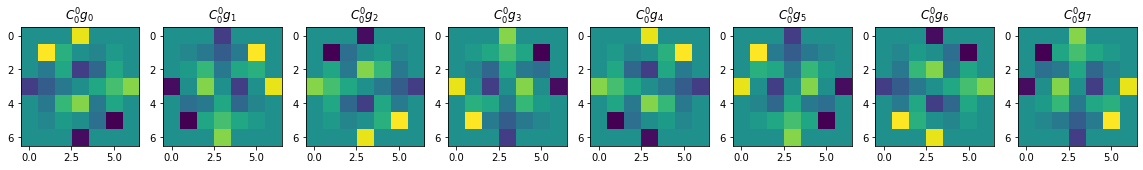

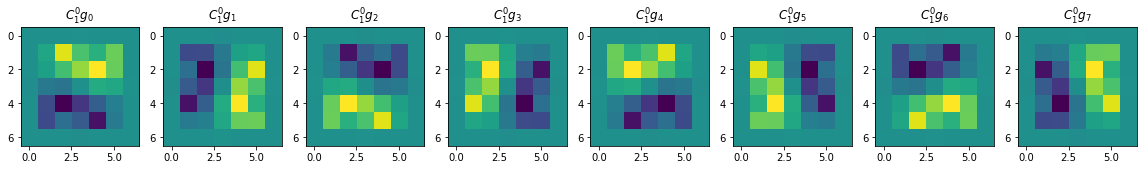

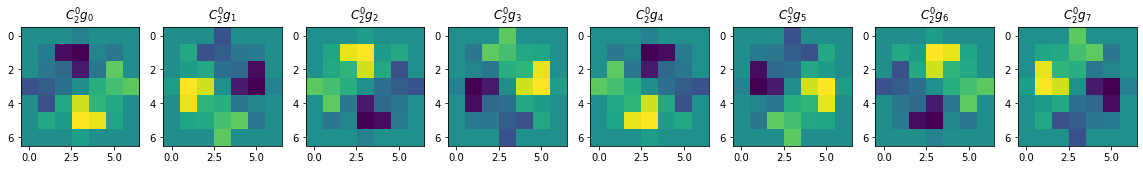

In [10]:
visualize_lifting_kernels(liftconv.conv_kernel[:, :3, :1, :, :].detach())
liftconv.conv_kernel.shape
g_elems

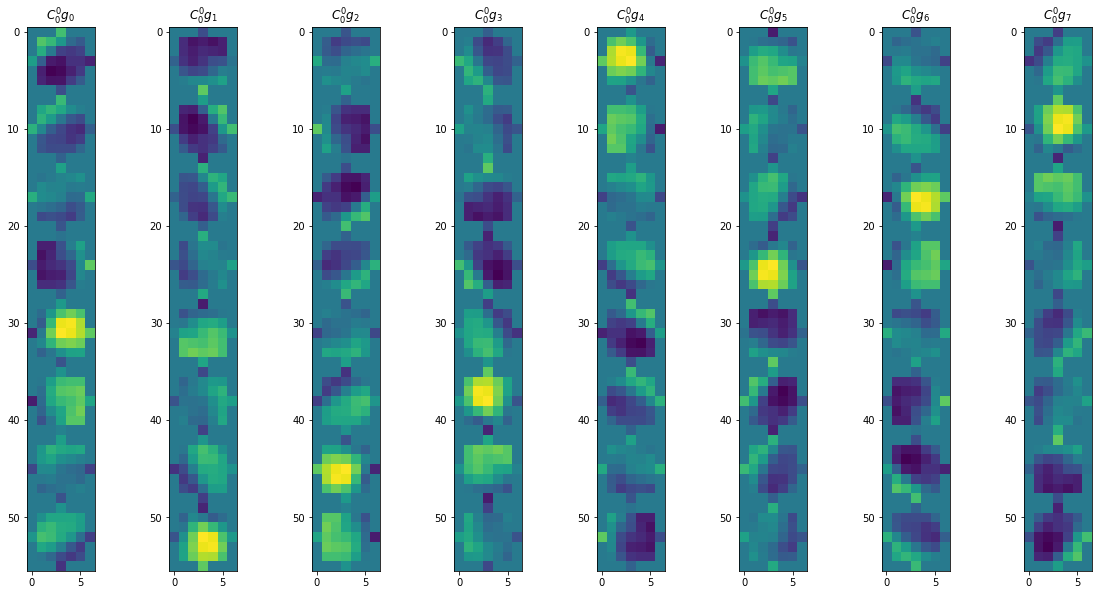

In [11]:
visualize_group_kernels(gconv.conv_kernel[:, :1, :1, :, :].detach())

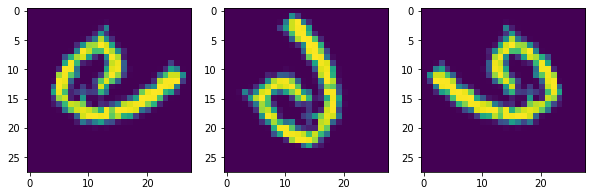

In [12]:
from datasets import RotatedMNIST
from torch.utils.data import Dataset, DataLoader

training_set = RotatedMNIST(
        partition="train",
        augment="None",
        root=os.path.join(os.path.dirname(os.getcwd()), "data"),
)

training_loader = DataLoader(
    training_set,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

# obtain a set of samples
samples, _ = next(iter(training_loader))
# rotate the set of samples
samples_rot = TF.rotate(samples, 90)
# flip the set of samples
samples_flip = torch.flip(samples, [-1])

no_rows = 1
no_cols = 3

fig = plt.figure(figsize=(10,15))
ax_1 = fig.add_subplot(1, 3, 1)
ax_1.imshow(samples[0, 0, :, :])
ax_1 = fig.add_subplot(1, 3, 2)
ax_1.imshow(samples_rot[0, 0, :, :])
ax_3 = fig.add_subplot(1, 3, 3)
ax_3.imshow(samples_flip[0, 0, :, :])

plt.show()

In [13]:
lifting_conv_acts, grid_H = liftconv(samples)
lifting_conv_acts = torch.relu(lifting_conv_acts)
group_conv_acts, grid_H = gconv([lifting_conv_acts, grid_H])

In [14]:
lifting_conv_acts_rot, grid_H = liftconv(samples_rot)
lifting_conv_acts_rot = torch.relu(lifting_conv_acts_rot)
group_conv_acts_rot, grid_H = gconv([lifting_conv_acts_rot, grid_H])

In [15]:
lifting_conv_acts_flip, grid_H = liftconv(samples_flip)
lifting_conv_acts_flip = torch.relu(lifting_conv_acts_flip)
group_conv_acts_flip, grid_H = gconv([lifting_conv_acts_flip, grid_H])

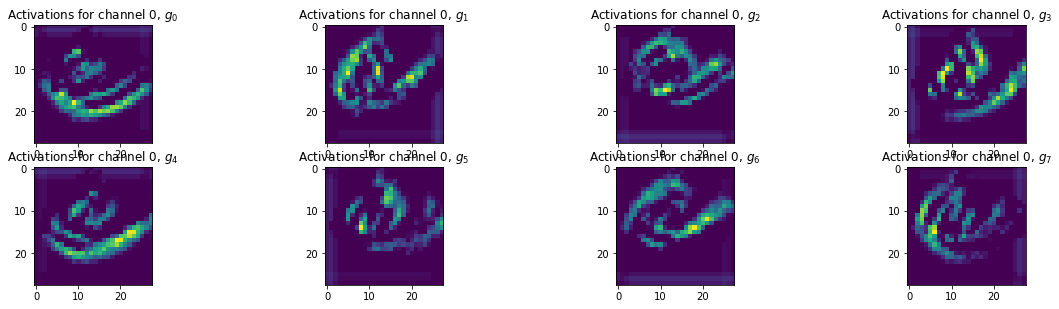

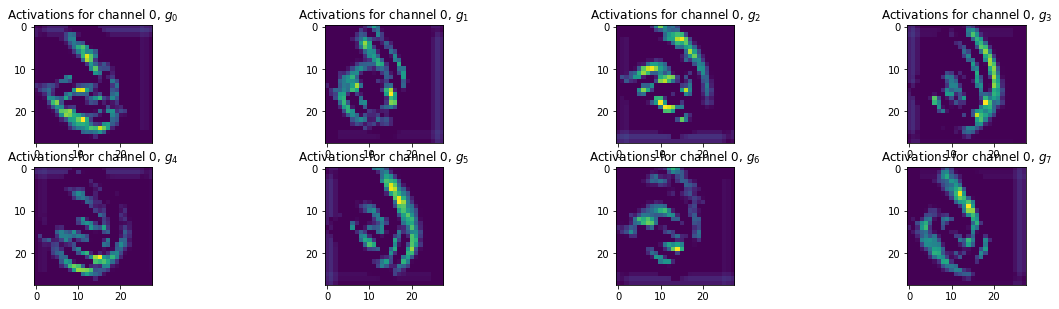

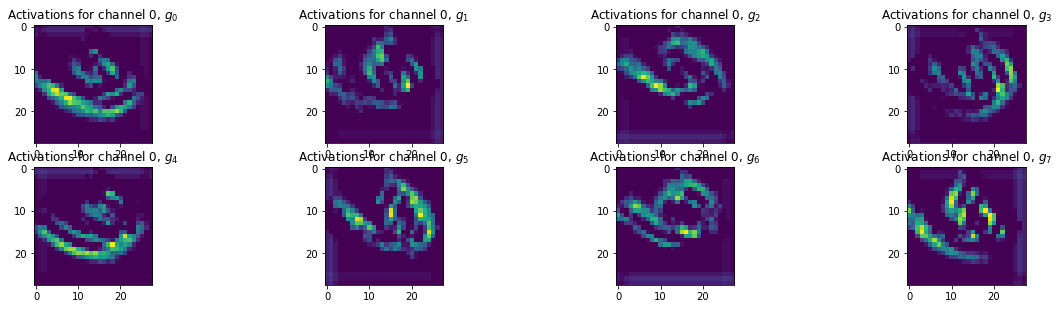

In [16]:
visualize_activations(lifting_conv_acts.detach().numpy())
visualize_activations(lifting_conv_acts_rot.detach().numpy())
visualize_activations(lifting_conv_acts_flip.detach().numpy())

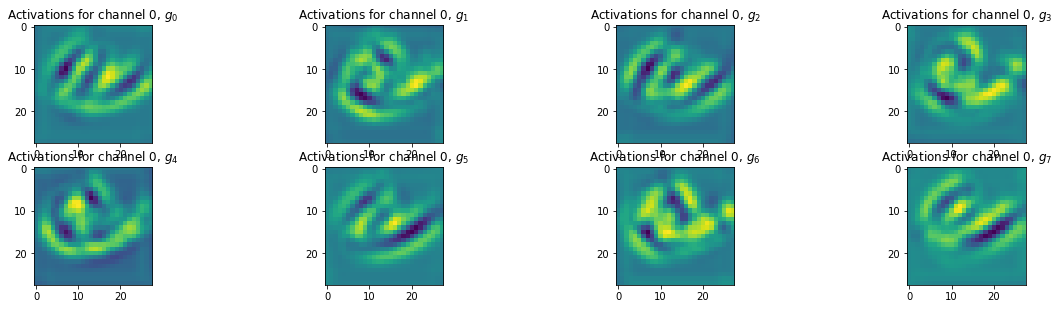

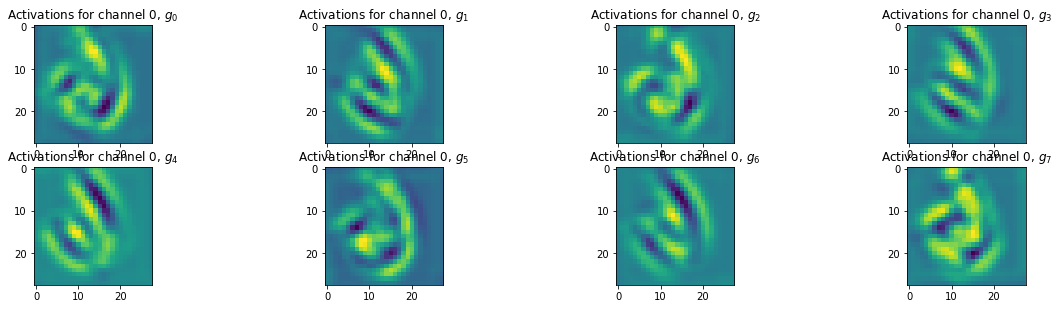

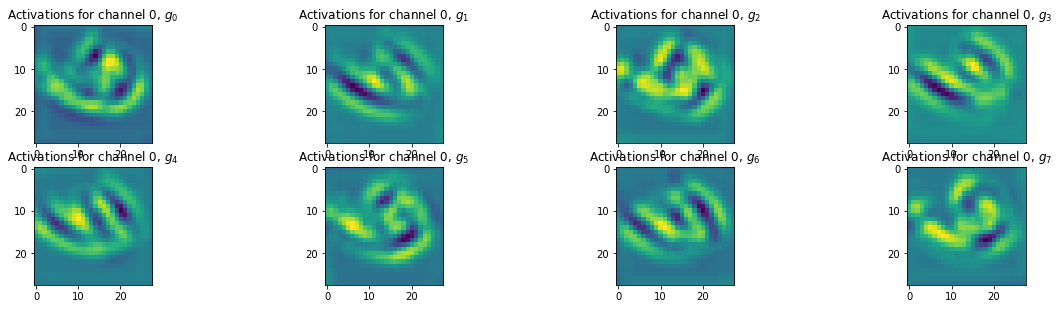

In [17]:
visualize_activations(group_conv_acts.detach().numpy())
visualize_activations(group_conv_acts_rot.detach().numpy())
visualize_activations(group_conv_acts_flip.detach().numpy())